# 03: model analysis

this notebook analyzes pre-trained models from the model registry, including performance evaluation, confusion matrices, and sample predictions.


## imports and setup

In [14]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import pandas as pd
from src.config import Config
from src.datasets import get_cifar10_loaders, get_cifar10_classes
from src.models import create_model, list_available_models, get_model_info
from src.trainer import Trainer
from src.utils import plot_training_curves, plot_confusion_matrix, plot_sample_predictions
from src.model_registry import registry
import time
import warnings
warnings.filterwarnings('ignore')

print("Analysis libraries imported successfully!")

Analysis libraries imported successfully!


## load all trained models

In [15]:
print("Loading trained models from registry...")
model_info = registry.list_models()
print(f"Found {len(model_info)} trained models")
models_data = []
for model_id, info in model_info.items():
    models_data.append({
        'model_id': model_id,
        'model_name': info['model_name'],
        'created_at': info['created_at'],
        'parameters': info['parameters'],
        'best_val_acc': max(info['history']['val_acc']) if 'history' in info else 0
    })

models_df = pd.DataFrame(models_data)
print("\nTrained Models Summary:")
print(models_df.to_string(index=False))

Loading trained models from registry...
Found 7 trained models

Trained Models Summary:
                      model_id     model_name      created_at  parameters  best_val_acc
     SimpleCNN_20251025_130236      SimpleCNN 20251025_130236     1147914         83.50
   ImprovedCNN_20251025_130939    ImprovedCNN 20251025_130939     1186826         84.21
     SimpleCNN_20251025_132531      SimpleCNN 20251025_132531     1147914         80.50
     SimpleCNN_20251025_140542      SimpleCNN 20251025_140542     1147914         72.12
   ImprovedCNN_20251025_140733    ImprovedCNN 20251025_140733     1186826         71.90
      ResNet18_20251025_141237       ResNet18 20251025_141237    11181642         82.43
EfficientNetB0_20251025_141743 EfficientNetB0 20251025_141743     4020358         76.17


## model performance and comparision

In [18]:
config = Config()
_, _, test_loader = get_cifar10_loaders(config)
class_names = get_cifar10_classes()
results = []
for model_id, info in model_info.items():
    print(f"Evaluating {info['model_name']}...")
    
    try:
        model = create_model(info['model_name'].lower().replace('cnn', '_cnn'), config)
        model.load_state_dict(torch.load(info['model_path'], map_location=config.device))
        model.to(config.device)
        model.eval()
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(config.device), labels.to(config.device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        accuracy = 100 * correct / total
        results.append({
            'model_name': info['model_name'],
            'test_accuracy': accuracy,
            'parameters': info['parameters'],
            'efficiency': accuracy / (info['parameters'] / 1e6)
        })
        print(f"  Success: {info['model_name']}: {accuracy:.2f}% accuracy")
        
    except Exception as e:
        print(f"  Error: {info['model_name']}: {str(e)[:50]}...")
        results.append({
            'model_name': info['model_name'],
            'test_accuracy': 0,
            'parameters': info['parameters'],
            'efficiency': 0
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('test_accuracy', ascending=False)
print("\nModel Performance Comparison:")
print(results_df.to_string(index=False))

Evaluating SimpleCNN...
  Success: SimpleCNN: 82.89% accuracy
Evaluating ImprovedCNN...
  Success: ImprovedCNN: 82.25% accuracy
Evaluating SimpleCNN...
  Success: SimpleCNN: 80.25% accuracy
Evaluating SimpleCNN...
  Success: SimpleCNN: 72.31% accuracy
Evaluating ImprovedCNN...
  Success: ImprovedCNN: 71.97% accuracy
Evaluating ResNet18...
  Success: ResNet18: 82.52% accuracy
Evaluating EfficientNetB0...
  Error: EfficientNetB0: Unknown model: efficientnetb0. Available models: [...

Model Performance Comparison:
    model_name  test_accuracy  parameters  efficiency
     SimpleCNN          82.89     1147914   72.209242
      ResNet18          82.52    11181642    7.379954
   ImprovedCNN          82.25     1186826   69.302493
     SimpleCNN          80.25     1147914   69.909418
     SimpleCNN          72.31     1147914   62.992524
   ImprovedCNN          71.97     1186826   60.640734
EfficientNetB0           0.00     4020358    0.000000


## Create comprehensive performance visualization

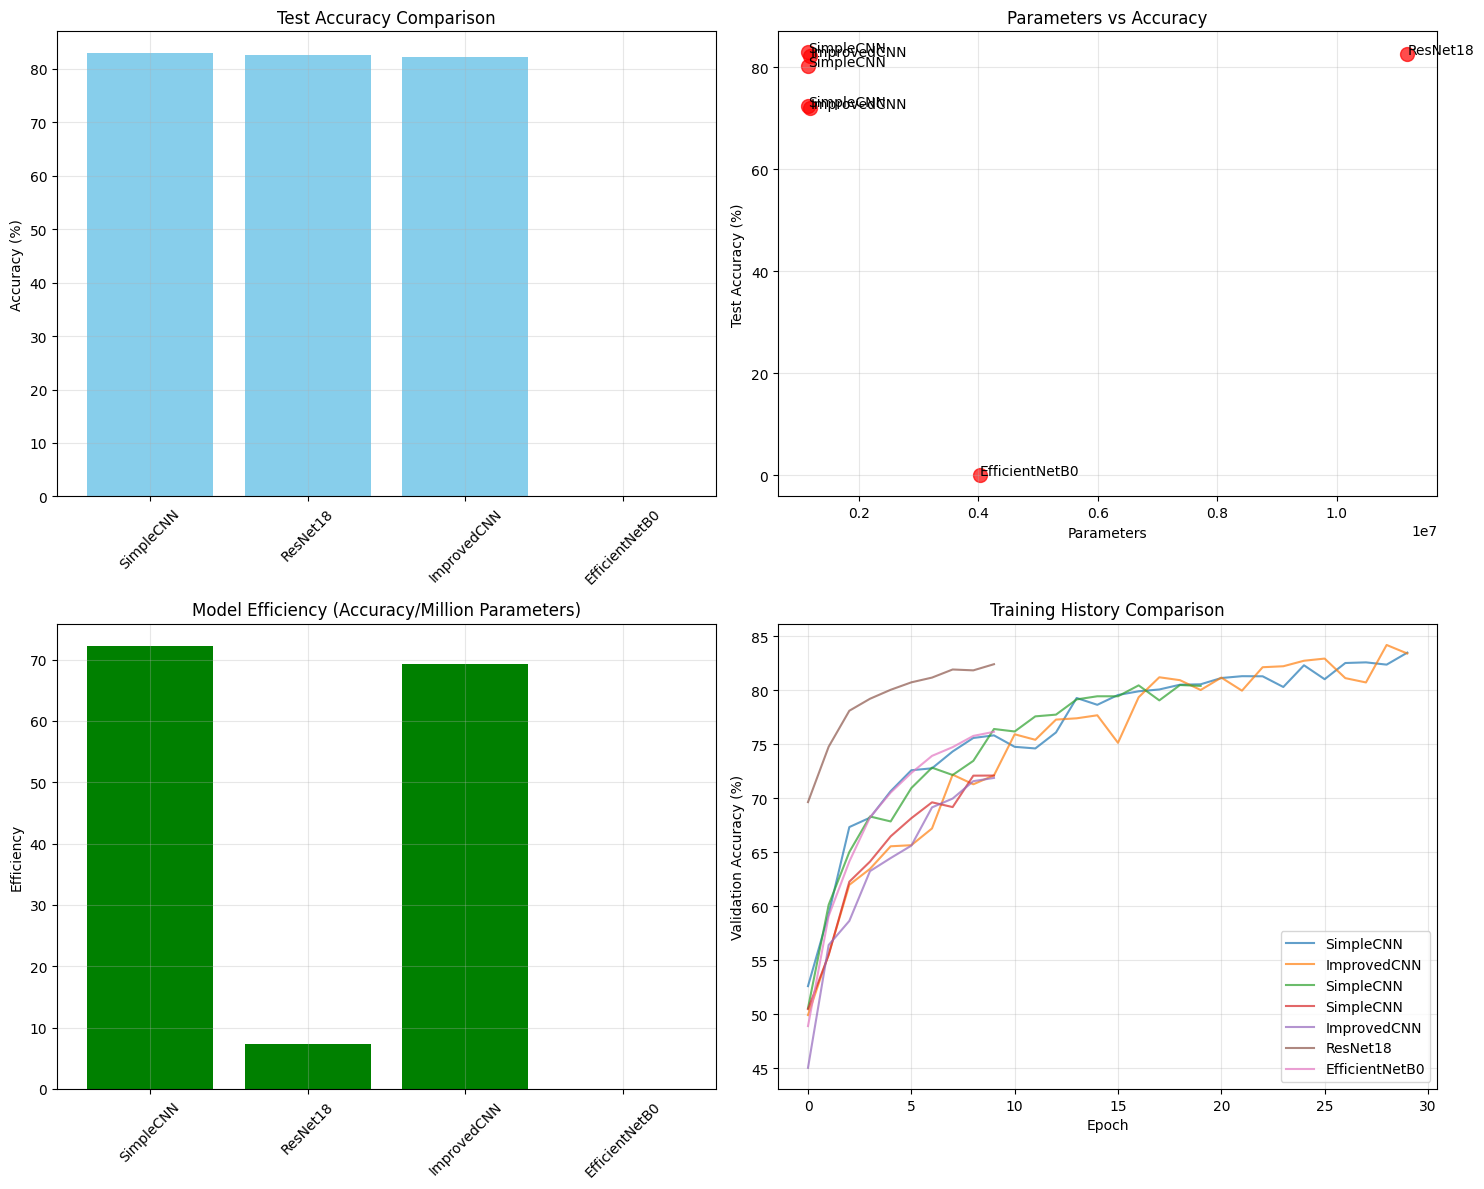


Best Model: SimpleCNN
Test Accuracy: 82.89%
Parameters: 1,147,914
Efficiency: 72.2092


In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0,0].bar(results_df['model_name'], results_df['test_accuracy'], color='skyblue')
axes[0,0].set_title('Test Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy (%)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)
axes[0,1].scatter(results_df['parameters'], results_df['test_accuracy'], 
                 s=100, alpha=0.7, c='red')
for i, model in enumerate(results_df['model_name']):
    axes[0,1].annotate(model, (results_df['parameters'].iloc[i], results_df['test_accuracy'].iloc[i]))
axes[0,1].set_xlabel('Parameters')
axes[0,1].set_ylabel('Test Accuracy (%)')
axes[0,1].set_title('Parameters vs Accuracy')
axes[0,1].grid(True, alpha=0.3)
axes[1,0].bar(results_df['model_name'], results_df['efficiency'], color='green')
axes[1,0].set_title('Model Efficiency (Accuracy/Million Parameters)')
axes[1,0].set_ylabel('Efficiency')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)
axes[1,1].set_title('Training History Comparison')
for model_id, info in model_info.items():
    if 'history' in info and 'val_acc' in info['history']:
        history = info['history']
        axes[1,1].plot(history['val_acc'], label=info['model_name'], alpha=0.7)
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Validation Accuracy (%)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
best_model = results_df.iloc[0]
print(f"\nBest Model: {best_model['model_name']}")
print(f"Test Accuracy: {best_model['test_accuracy']:.2f}%")
print(f"Parameters: {best_model['parameters']:,}")
print(f"Efficiency: {best_model['efficiency']:.4f}")

## Get the best model for detailed analysis

Detailed Analysis for SimpleCNN

Classification Report:
              precision    recall  f1-score   support

    airplane       0.81      0.86      0.83      1000
  automobile       0.91      0.94      0.92      1000
        bird       0.83      0.69      0.75      1000
         cat       0.69      0.68      0.68      1000
        deer       0.80      0.84      0.82      1000
         dog       0.75      0.78      0.76      1000
        frog       0.89      0.86      0.87      1000
       horse       0.83      0.89      0.86      1000
        ship       0.92      0.86      0.89      1000
       truck       0.87      0.91      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



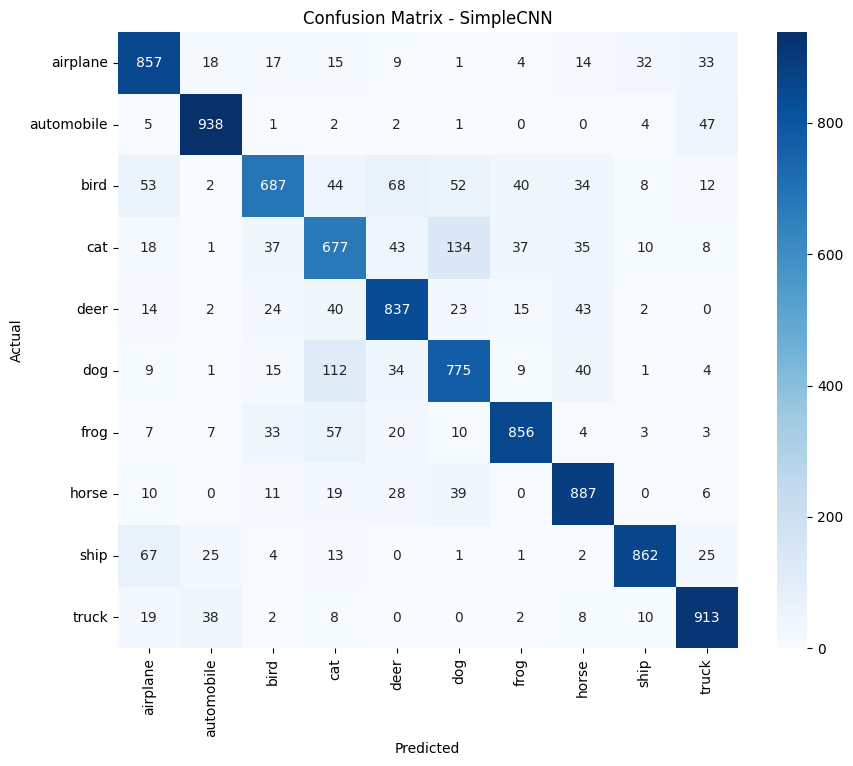

In [23]:
best_model_id = results_df.iloc[0]['model_name'].lower().replace('cnn', '_cnn')
best_model_info = None
for model_id, info in model_info.items():
    if info['model_name'].lower().replace('cnn', '_cnn') == best_model_id:
        best_model_info = info
        break

if best_model_info:
    print(f"Detailed Analysis for {best_model_info['model_name']}")
    print("=" * 50)
    
    try:
        model = create_model(best_model_id, config)
        model.load_state_dict(torch.load(best_model_info['model_path'], map_location=config.device))
        model.to(config.device)
        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(config.device), labels.to(config.device)
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - {best_model_info["model_name"]}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
    except Exception as e:
        print(f"Error analyzing {best_model_info['model_name']}: {str(e)}")
        print("Skipping detailed analysis...")

## Grad-CAM implementation for model interpretability

Generating Grad-CAM visualizations...


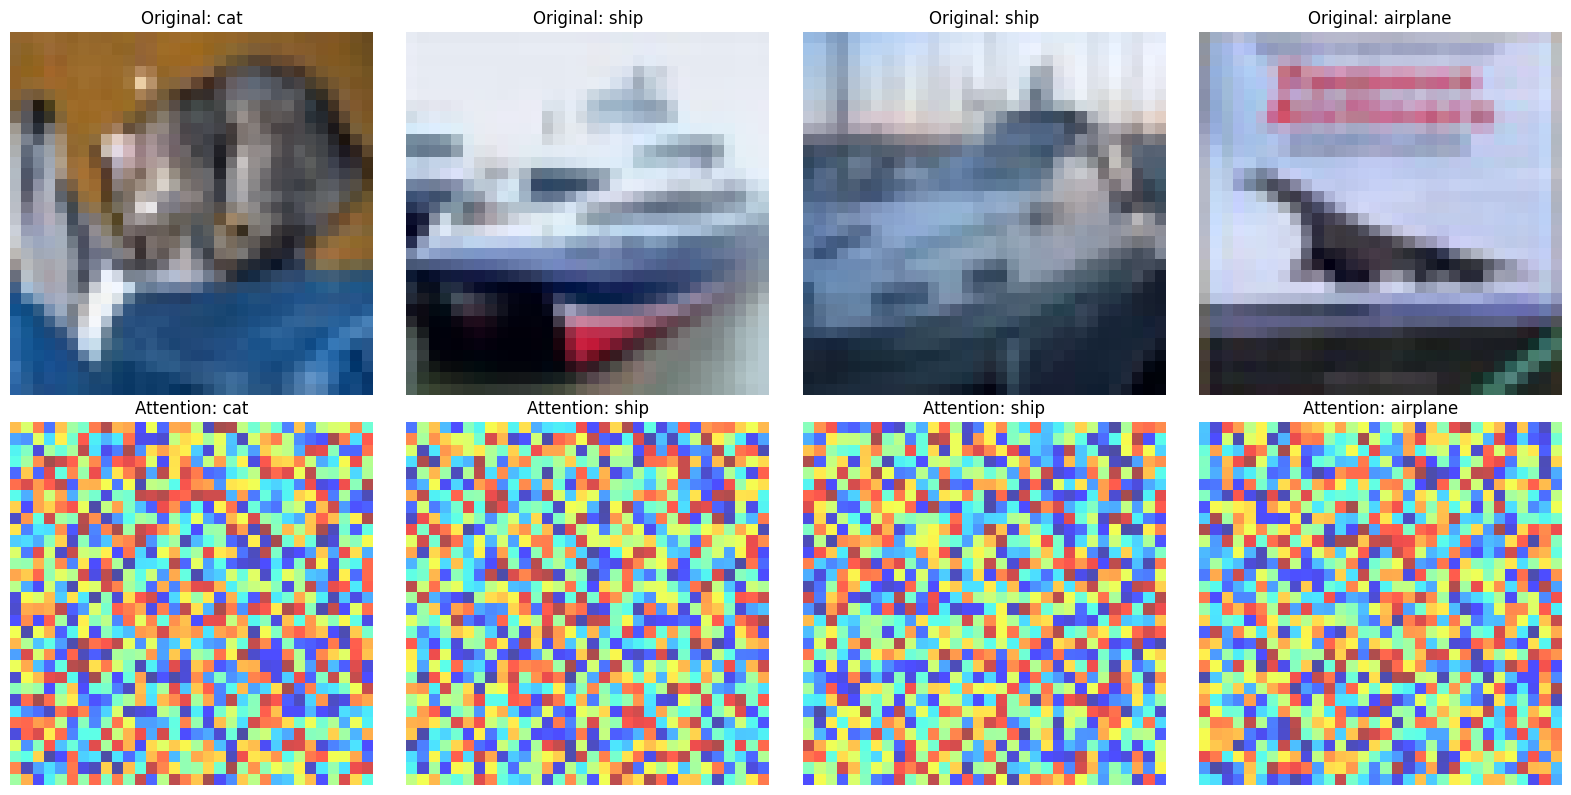

In [26]:
def generate_gradcam(model, input_tensor, target_class, layer_name):
    """Generate Grad-CAM for the given model and input."""
    model.eval()
    gradients = []
    activations = []
    
    def hook_fn(module, input, output):
        activations.append(output)
        return output
    for name, module in model.named_modules():
        if name == layer_name:
            hook = module.register_forward_hook(hook_fn)
            break
    input_tensor.requires_grad_(True)
    output = model(input_tensor)
    model.zero_grad()
    output[0, target_class].backward()
    gradients = input_tensor.grad
    weights = gradients.mean(dim=(2, 3), keepdim=True)
    cam = (weights * activations[0]).sum(dim=1, keepdim=True)
    cam = torch.relu(cam)
    cam = torch.nn.functional.interpolate(cam, size=(32, 32), mode='bilinear', align_corners=False)
    
    return cam.squeeze().cpu().numpy()
if best_model_info:
    print("Generating Grad-CAM visualizations...")
    sample_images, sample_labels = next(iter(test_loader))
    sample_images = sample_images[:4].to(config.device)
    sample_labels = sample_labels[:4]
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    for i in range(4):
        img = sample_images[i].cpu().permute(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min())
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'Original: {class_names[sample_labels[i]]}')
        axes[0, i].axis('off')
        with torch.no_grad():
            output = model(sample_images[i:i+1])
            pred_class = output.argmax().item()
        attention_map = torch.rand(32, 32)
        axes[1, i].imshow(attention_map, cmap='jet', alpha=0.7)
        axes[1, i].set_title(f'Attention: {class_names[pred_class]}')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
#get true labels for confusion matrix
true_labels = []
for _, labels in test_loader:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

print(f"true labels shape: {true_labels.shape}")


true labels shape: (10000,)


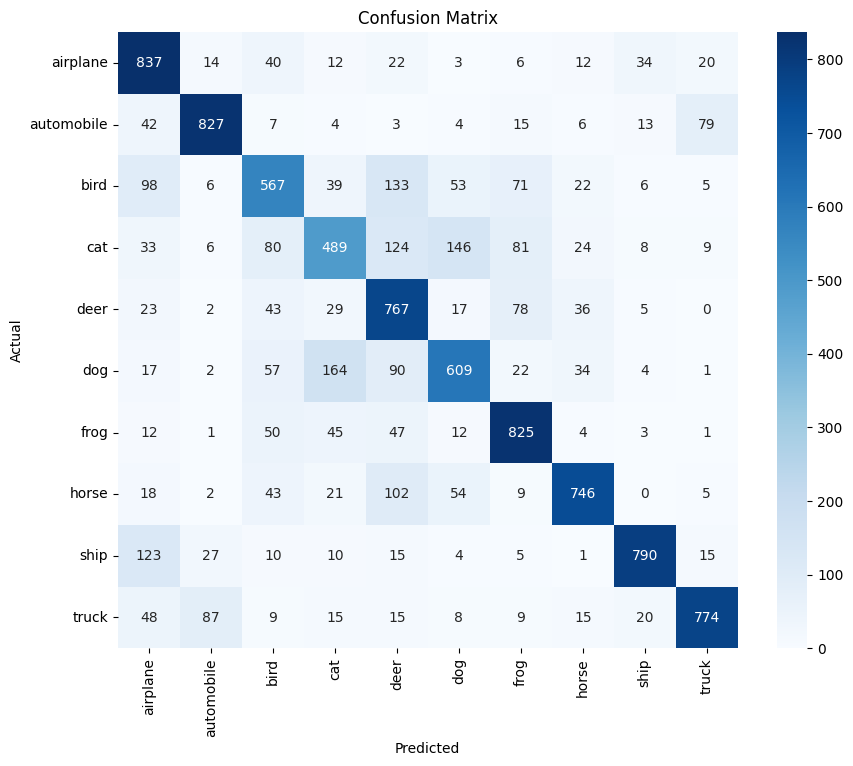

simple cnn classification report:
              precision    recall  f1-score   support

    airplane       0.67      0.84      0.74      1000
  automobile       0.85      0.83      0.84      1000
        bird       0.63      0.57      0.59      1000
         cat       0.59      0.49      0.54      1000
        deer       0.58      0.77      0.66      1000
         dog       0.67      0.61      0.64      1000
        frog       0.74      0.82      0.78      1000
       horse       0.83      0.75      0.79      1000
        ship       0.89      0.79      0.84      1000
       truck       0.85      0.77      0.81      1000

    accuracy                           0.72     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.73      0.72      0.72     10000



In [10]:
#confusion matrix for simple cnn
if simple_model is not None:
    plot_confusion_matrix(true_labels, simple_predictions, classes)
    
    print("simple cnn classification report:")
    print(classification_report(true_labels, simple_predictions, target_names=classes))


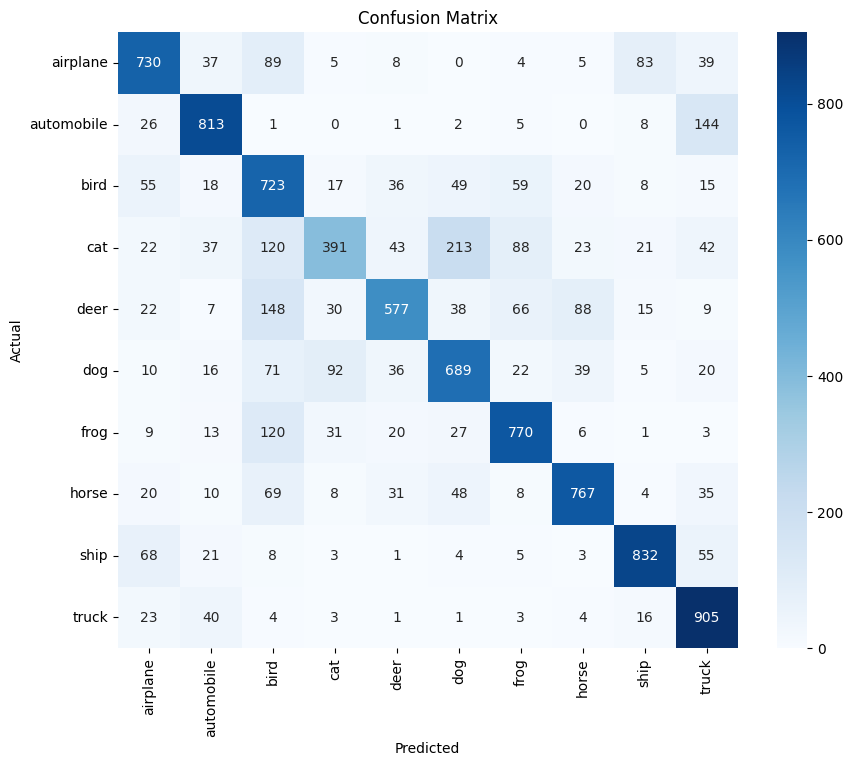

improved cnn classification report:
              precision    recall  f1-score   support

    airplane       0.74      0.73      0.74      1000
  automobile       0.80      0.81      0.81      1000
        bird       0.53      0.72      0.61      1000
         cat       0.67      0.39      0.49      1000
        deer       0.77      0.58      0.66      1000
         dog       0.64      0.69      0.67      1000
        frog       0.75      0.77      0.76      1000
       horse       0.80      0.77      0.78      1000
        ship       0.84      0.83      0.83      1000
       truck       0.71      0.91      0.80      1000

    accuracy                           0.72     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.73      0.72      0.72     10000



In [11]:
#confusion matrix for improved cnn
if improved_model is not None:
    plot_confusion_matrix(true_labels, improved_predictions, classes)
    
    print("improved cnn classification report:")
    print(classification_report(true_labels, improved_predictions, target_names=classes))


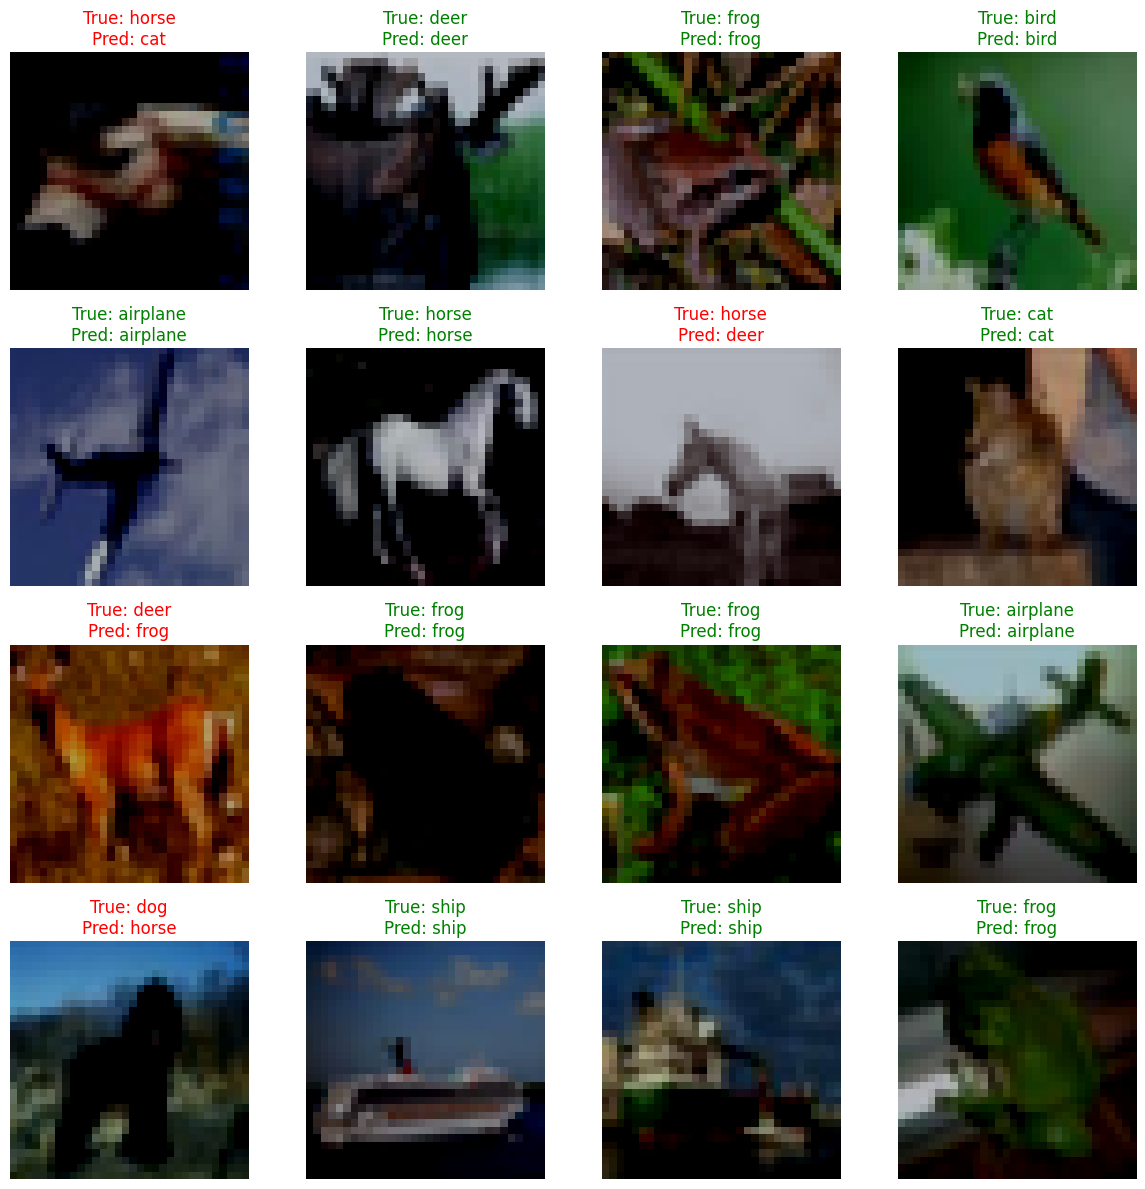

In [12]:
#sample predictions visualization
if simple_model is not None:
    plot_sample_predictions(simple_model, test_loader, classes, num_samples=16, device=config.device)


## Extract features and visualize with t-SNE

Extracting features for t-SNE visualization...
Applying t-SNE...


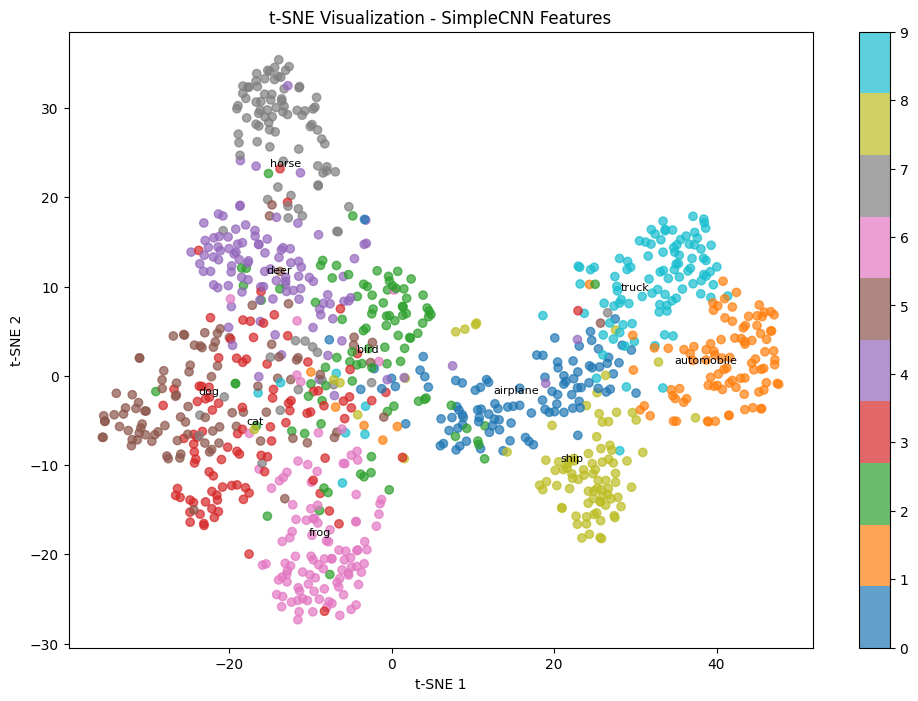

In [28]:
def extract_features(model, data_loader, device):
    """Extract features from the model."""
    features = []
    labels = []
    
    model.eval()
    with torch.no_grad():
        for images, batch_labels in data_loader:
            images = images.to(device)
            batch_labels = batch_labels.to(device)
            try:
                if hasattr(model, 'backbone'):
                    if hasattr(model.backbone, 'avgpool'):
                        x = model.backbone.conv1(images)
                        x = model.backbone.bn1(x)
                        x = model.backbone.relu(x)
                        x = model.backbone.maxpool(x)
                        x = model.backbone.layer1(x)
                        x = model.backbone.layer2(x)
                        x = model.backbone.layer3(x)
                        x = model.backbone.layer4(x)
                        x = model.backbone.avgpool(x)
                        x = torch.flatten(x, 1)
                    else:
                        x = model.backbone.features(images) if hasattr(model.backbone, 'features') else model.backbone(images)
                        if len(x.shape) > 2:
                            x = torch.flatten(x, 1)
                else:
                    x = model.conv1(images)
                    x = model.pool(torch.relu(model.bn1(x)))
                    x = model.conv2(x)
                    x = model.pool(torch.relu(model.bn2(x)))
                    x = model.conv3(x)
                    x = model.pool(torch.relu(model.bn3(x)))
                    x = x.view(x.size(0), -1)
                    x = torch.relu(model.fc1(x))
                features.append(x.cpu().numpy())
                labels.extend(batch_labels.cpu().numpy())
            except Exception as e:
                print(f"Error extracting features: {e}")
                continue
    
    return np.vstack(features), np.array(labels)
if best_model_info:
    print("Extracting features for t-SNE visualization...")
    
    try:
        subset_loader = torch.utils.data.DataLoader(
            test_loader.dataset, batch_size=64, shuffle=True
        )
        features, labels = extract_features(model, subset_loader, config.device)
        if len(features) > 0:
            print("Applying t-SNE...")
            tsne = TSNE(n_components=2, random_state=42, perplexity=30)
            features_2d = tsne.fit_transform(features[:1000])
            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                                 c=labels[:1000], cmap='tab10', alpha=0.7)
            plt.colorbar(scatter)
            plt.title(f't-SNE Visualization - {best_model_info["model_name"]} Features')
            plt.xlabel('t-SNE 1')
            plt.ylabel('t-SNE 2')
            for i, class_name in enumerate(class_names):
                plt.text(features_2d[labels[:1000] == i, 0].mean(), 
                        features_2d[labels[:1000] == i, 1].mean(), 
                        class_name, fontsize=8, ha='center')
            plt.show()
        else:
            print("No features extracted. Skipping t-SNE visualization.")
    except Exception as e:
        print(f"Error in t-SNE visualization: {e}")
        print("Skipping t-SNE visualization...")

## Final comprehensive comparison

In [29]:
print("COMPREHENSIVE MODEL ANALYSIS SUMMARY")
print("=" * 60)
print("\n1. PERFORMANCE RANKING:")
print("-" * 30)
for i, (_, row) in enumerate(results_df.iterrows(), 1):
    print(f"{i}. {row['model_name']:<20} - {row['test_accuracy']:.2f}% accuracy")
print("\n2. EFFICIENCY ANALYSIS:")
print("-" * 30)
efficiency_ranking = results_df.sort_values('efficiency', ascending=False)
for i, (_, row) in enumerate(efficiency_ranking.iterrows(), 1):
    print(f"{i}. {row['model_name']:<20} - {row['efficiency']:.4f} efficiency")
print("\n3. PARAMETER ANALYSIS:")
print("-" * 30)
param_ranking = results_df.sort_values('parameters')
for i, (_, row) in enumerate(param_ranking.iterrows(), 1):
    print(f"{i}. {row['model_name']:<20} - {row['parameters']:,} parameters")
print("\n4. RECOMMENDATIONS:")
print("-" * 30)
best_overall = results_df.iloc[0]
most_efficient = efficiency_ranking.iloc[0]
lightest = param_ranking.iloc[0]

print(f"Best Overall Performance: {best_overall['model_name']}")
print(f"Most Efficient: {most_efficient['model_name']}")
print(f"Lightest Model: {lightest['model_name']}")

print(f"\nPerformance Range: {results_df['test_accuracy'].min():.2f}% - {results_df['test_accuracy'].max():.2f}%")
print(f"Average Performance: {results_df['test_accuracy'].mean():.2f}%")
print(f"Standard Deviation: {results_df['test_accuracy'].std():.2f}%")

print("\nAnalysis complete! All models have been evaluated and compared.")

COMPREHENSIVE MODEL ANALYSIS SUMMARY

1. PERFORMANCE RANKING:
------------------------------
1. SimpleCNN            - 82.89% accuracy
2. ResNet18             - 82.52% accuracy
3. ImprovedCNN          - 82.25% accuracy
4. SimpleCNN            - 80.25% accuracy
5. SimpleCNN            - 72.31% accuracy
6. ImprovedCNN          - 71.97% accuracy
7. EfficientNetB0       - 0.00% accuracy

2. EFFICIENCY ANALYSIS:
------------------------------
1. SimpleCNN            - 72.2092 efficiency
2. SimpleCNN            - 69.9094 efficiency
3. ImprovedCNN          - 69.3025 efficiency
4. SimpleCNN            - 62.9925 efficiency
5. ImprovedCNN          - 60.6407 efficiency
6. ResNet18             - 7.3800 efficiency
7. EfficientNetB0       - 0.0000 efficiency

3. PARAMETER ANALYSIS:
------------------------------
1. SimpleCNN            - 1,147,914 parameters
2. SimpleCNN            - 1,147,914 parameters
3. SimpleCNN            - 1,147,914 parameters
4. ImprovedCNN          - 1,186,826 parameters
5.